In [1]:
import numpy as np
import pandas as pd
import re
import requests
#import urllib.request as request
from bs4 import BeautifulSoup
from collections import Counter
import time
import matplotlib.pyplot as plt
%matplotlib inline
import time
from matplotlib.backends.backend_pdf import PdfPages
import urllib.parse
import unidecode
import seaborn as sns
from collections import Counter, defaultdict
import codecs
from numpy import percentile
from requests_futures.sessions import FuturesSession
import dill
import itertools
from wordcloud import WordCloud, STOPWORDS 
from matplotlib.figure import Figure
import spacy
import en_core_web_sm
nlp = spacy.load('en', disable=['parser','ner'])
from sklearn.decomposition import LatentDirichletAllocation
from hlda.sampler import HierarchicalLDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## Data Preparation

Data is collected by scraping arxiv.com. Using FuturesSession from requests_futures, HTTP requests are parallelized. Beautiful-Soup is used to parse the html. We extract the _publication titles_ and the _publication category_ (the broad research topic each publication belongs to).  

In [2]:
def title_research_func(response):
    '''
    This function extracts publication titles and 
    the publication category. 
    '''
    soup = BeautifulSoup(response.text,'lxml')
    #print(soup)
    titles = []
    for line in soup.select("div.list-title.mathjax"):
        title = re.sub(r'\n','',line.text)
        title = re.sub(r'^\s+','',title)
        title = re.sub(r'\s+$','',title)
        title = re.sub(r'^Title:\s','',title)
        titles.append(title)
        #print(title)
       
    areas = []
    for line in soup.select("div.list-subjects"):
        cross_list = []
        area = re.sub(r'\n','',line.text)
        area = re.sub(r'^\s+','',area)
        area = re.sub(r'\s+$','',area)
        area = re.sub(r'^Subjects:\s','',area)
        #print(area)
        for a in area.split('; '):
            cross_list.append(a)
        #print(cross_list)
        areas.append(cross_list) 
    return titles,areas

In [37]:
title_research_area = []
session = FuturesSession(max_workers=5)
futures = []
per_page = 200
year = 10
start = time.time()
#url = f'https://export.arxiv.org/list/astro-ph/{year}?skip=0&show=25'
url = f'https://export.arxiv.org/list/physics/{year}?abs=true&skip=0&show=25'
page = requests.get(url)
soup = BeautifulSoup(page.text,'lxml')
match = re.search(r'(total\sof)\s([\w]+)\s(entries)',str(soup))
total_papers = int(match.group(2))
start_vals = np.arange(0,np.divmod(total_papers,per_page)[0]+1)*per_page

for vals in start_vals:
    #url = f'https://export.arxiv.org/list/astro-ph/{year}?skip={vals}&show={per_page}'
    url = f'https://export.arxiv.org/list/physics/{year}?abs=true&skip={vals}&show={per_page}'
    futures.append(session.get(url))

for r in [title_research_func(future.result()) for future in futures]:
    title_research_area.append(r)
end = time.time()
print('Time taken = ', '{:2.2}'.format(end - start))

Time taken =  2.9e+01


Let's dill and save our raw data to avoid downloading from the server every time we run the notebook.

In [40]:
#dill.dump(title_research_area,open('data/2010_title_research_area.pkd','wb'))

In [2]:
title_research_area = dill.load(open('data/2020_astro_ph_title_research_area.pkd', 'rb'))

In [3]:
research_areas = []
titles = []
for ent in title_research_area:
    for title in ent[0]:
        titles.append(title)
    for area in ent[1]:
        research_areas.append(area)

## Test Preprocessing

First, let's clean the titles by removing punctuations, math symbols and numbers.

In [5]:
def text_clean_func(corpus_raw):
    '''
    Removing punctuations, math symbols and numbers.
    '''
    corpus = []
    for text in corpus_raw:
        text_no_comma = re.sub(r'[=<>^,\:\.\)\($\+\"\'\?\/\_\{\}\\]',' ',text)
        text_no_comma = re.sub(r'  ',' ',text_no_comma)
        text_no_comma = re.sub(r'  ',' ',text_no_comma)
        text_no_comma = re.sub(r'-','',text_no_comma)
        text_no_comma = re.sub('[\d]+','',text_no_comma)
        corpus.append(text_no_comma)
    return corpus

In [9]:
titles_final = text_clean_func(titles)

## Lemmatization

Now let's lemmatize our text corpus. Lemmatization refers to reducing each word in the corpus to its lemma, or dictionary form. Stemming is a related process in which the inflected forms of a word are truncated to reduce them to a common base form. However, it is crude as compared to lemmatization and therefore not used here.

In [7]:
def tokenize_lemma(doc):
    '''
    Lemmatization
    '''
    return [ w.lemma_.lower() for w in nlp(doc) 
                      if w.pos_ not in ['PUNCT', 'SPACE', 'SYM', 'CCONJ']
                      and w.lemma_ not in ['_', '.'] ]

## Stopwords

We remove stopwords such as 'about', 'above', 'across', 'after', etc.

In [8]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS
stopwords.union(['-pron-'])

stopwords = set(tokenize_lemma(' '.join(list(stopwords))))

## Vectorizing the text

No that we have the lemmatizer and a set of stopwords, we use `CountVectorizer` to vectorize our text corpus. It returns a matrix with features or words (we have chosen bi-grams and tri-grams here) as columns and documents/titles as rows. The entries in the matrix contain the number of occurences of each word/bi-trigram in a document.

Next, we implement the `TfidfTransformer` which weighs the words by the inverse document frequency. 

In [64]:
max_features = 1000

cv = CountVectorizer(tokenizer=tokenize_lemma, 
                     stop_words=stopwords,
                      min_df=2, max_df=0.5, 
                      ngram_range=(2,3),
                      max_features=max_features)
counts = cv.fit_transform(titles_final)

tf = TfidfTransformer()
matrix = tf.fit_transform(counts)

## $K$-means clustering 

In $k$-means clustering, each document is viewed as a multi-dimensional vector of the matrix created from the `CountVectorizer` and `TfidfTransformer`. Two documents are similar to one another if their corresponding vectors are close to one another or, in other words, if the difference of their vectors is small in length. 

We can use this common clustering method to group our documents together to find "topics of research in Astophysics (astro-ph)". The $k$-means clustering is an unsupervised learning algorithm as we do not know the "right" number of clusters in which to group our data, but there exist some well-known tools that we could use to attempt to determine this number.  We will make the somewhat arbitrary choice to cluster our data into five clusters.

In [93]:
number_of_clusters = 5

kmc = KMeans(n_clusters=number_of_clusters, n_init=10, 
               random_state=117)  # random_state for consistency
kmc.fit(matrix)

KMeans(n_clusters=5, random_state=117)

The features in our model require some cleaning. The `CountVectorizer` described above uses bi-grams and tri-grams. In some cases, it results in 'black hole' and 'binary black hole' as two separate features. While there could certainly be documents where 'black hole' appears without 'binary' preceeding it, when we finally look at the top features/phrases for each cluster, having both 'black hole' and 'binary black hole' is less meaningful. Therefore, we write a function below that removes any bigram which is contained in a trigram. Having said that, it is important to note here that the matrix used for $k$-means clustering contains both phrases such as 'black hole' and 'binary black hole' for reasons mentioned above.   

In [87]:
def vocab_bi_tri(list_of_words):
    '''
    Cleans the features of the CountVectorizer
    '''
    trigram_clean_str = ''
    vocab_clean = ''
    bigram_clean_list = []
    index_list = []
    bigram_index_list = []
    for index,word in enumerate(list_of_words):
        if re.search(r'[\w]+\s[\w]+\s[\w]+', word):
            #print(index,word)
            trigram_clean_str += word + ' '
            vocab_clean += word + ','
            index_list.append(index)
        else:
            bigram_clean_list.append(word)
            bigram_index_list.append(index)
            
    bigram_tuple = zip(bigram_index_list,bigram_clean_list)
    for index,word in bigram_tuple:
        if word not in trigram_clean_str:
            vocab_clean += word + ','
            index_list.append(index)
    bi_tri_clean = vocab_clean.split(',')
    bi_tri_clean.pop()
    return [bi_tri_clean,index_list]        

Now let's take a look at the most important words in each cluster. The 5 clusters seem to be:

0. Dark matter halo-galaxy relation
1. Dark matter direct detection
2. Neutron stars and related phenomena
3. Black holes
4. Fast radio bursts

Notice that there is some overlap between clusters: 'milky way' appears in cluster 0 and 2. 'Neutron star' unexpectedly appears as a feature in Cluster 1 - Dark matter direct detection - pointing to the fact that perhaps the $k$-means clustering did not perform as well as we wanted it to.  

In [259]:
number_of_top_words = 10

cluster_words = np.argsort(kmc.cluster_centers_, axis=1)
terms = cv.get_feature_names()

top_words = set()

for i in range(number_of_clusters):
    print('Cluster {}: '.format(i))
    top_list = [terms[k] for k in cluster_words[i][-number_of_top_words:]]
    #print(top_list)
    print(vocab_bi_tri(top_list)[0][-5:])
    top_words = top_words.union([terms[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words = sorted(vocab_bi_tri(list(top_words))[0])

Cluster 0: 
['milky way', 'rotation curve', 'dovich effect', 'intrinsic alignment', 'halo model']
Cluster 1: 
['light dark', 'neutron star', 'xenont excess', 'subgev dark', 'direct detection']
Cluster 2: 
['milky way', 'star formation', 'gravitational wave', 'neutron star', 'magnetic field']
Cluster 3: 
['black hole merger', 'supermassive black hole', 'binary black hole', 'primordial black hole', 'gravitational wave']
Cluster 4: 
['repeat fast radio', 'fast radio burst', 'neutron star', 'dispersion measure', 'host galaxy']


## Visualizations

### Size of the clusters

First let's take a look at the number of documents in each cluster.

In [95]:
cluster_freq = [(key,value) for key,value in sorted(Counter(kmc.labels_.tolist()).items(),key=lambda item:item[0])]

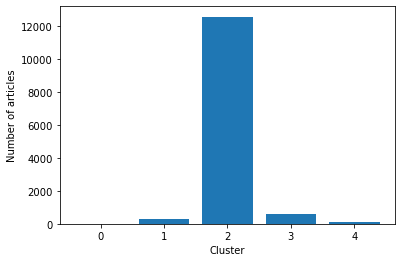

In [258]:
x = [ent[0] for ent in cluster_freq]
y = [ent[1] for ent in cluster_freq]
plt.bar(x,y)
plt.xlabel('Cluster')
plt.ylabel('Number of articles');

### Word frequencies

Next, we can look at the number of occurences in each cluster of some of the most frequent words in the corpus.

In [101]:
top_words_df = pd.DataFrame(counts.toarray(), columns=terms)[top_words]
top_words_df['Cluster'] = kmc.labels_.tolist()

In [102]:
top_words_df.head()

,binary black hole,black hole merger,dark energy,dark matter halo,direct detection,dispersion measure,dovich effect,fast radio burst,galaxy cluster,gammaray burst,...,radio burst source,repeat fast radio,rotation curve,spiral galaxy,star formation,subgev dark,supermassive black hole,white dwarf,xenont excess,Cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


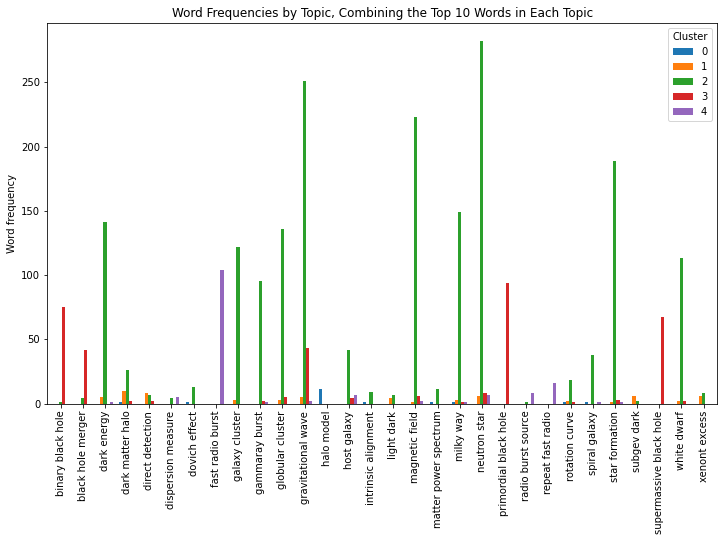

In [130]:
top_words_df.groupby('Cluster').sum().transpose().\
    plot.bar(figsize=(12,7), width=0.7).\
    set(ylabel='Word frequency', 
    title='Word Frequencies by Topic, Combining the Top {} Words in Each Topic'.format(number_of_top_words));

### Wordclouds

We can show the most frequent words in each cluster using a word cloud.

In [149]:
terms_clean = vocab_bi_tri(terms)[0]

In [153]:
words_df = pd.DataFrame(counts.toarray(), columns=terms)[terms_clean]
words_df['Cluster'] = kmc.labels_.tolist()

In [155]:
word_sum = words_df.groupby('Cluster').sum()

In [189]:
def plot_wordcloud(frequencies,ax):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(frequencies) 

    ax.imshow(wordcloud) 
    ax.axis("off") 

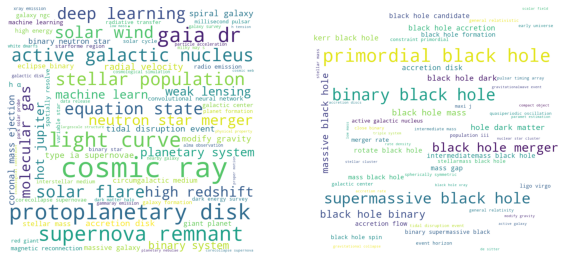

In [191]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
frequencies = {col:word_sum.loc[2,col] for col in word_sum.columns}
plot_wordcloud(frequencies,ax)

ax = fig.add_subplot(222)
frequencies = {col:word_sum.loc[3,col] for col in word_sum.columns}
plot_wordcloud(frequencies,ax)


## Visualization in a low dimensional space

We can use PCA to project the 1000-dimensional vector representation of our text corpus into a lower-dimensional space.

In [192]:
pca = PCA(n_components=2, random_state=117)
matrix_pca = pca.fit_transform(matrix.toarray())

matrix_pca.shape

(13600, 2)

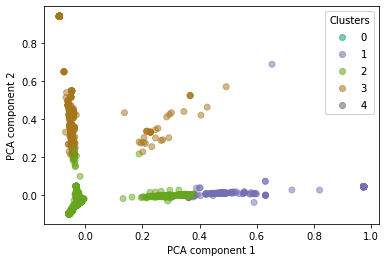

In [262]:
fig, ax = plt.subplots()

scatter = ax.scatter(matrix_pca[:,0], matrix_pca[:,1], 
                     c=word_df['Cluster'], 
            cmap='Dark2', alpha=0.5)
legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.set_xlabel('PCA component 1')
ax.set_ylabel('PCA component 2')
ax.add_artist(legend);

We see that some clusters, eg. Cluster 1 (purple) and 3 (brown) are relatively well-defined: most of the documents belonging to these clusters lie along one axis. There is some mixing in the other clusters, possibly because of the limitation of the projection down into a two-dimensional space.   

## Selecting the number of clusters

One way of attempting to evaluate the quality of a clustering is to use the so-called "silhouette score". Qualitatively it is related to how close the samples are to each other inside a cluster and how far apart they are to the next nearest cluster. It has a range between (-1,1). A score of 1 means that the clusters are very tightly grouped whereas a score of 0 means there is considerable overlap between clusters. A score of -1 indicates that a group of points was assigned to wrong cluster.

Another method to evaluate clustering is the 'inertia'. It is related to the distance from each data point to the center of the cluster to which it is assigned. One drawback of the inertia is that it keeps decreasing with the number of clusters. Silhoutte scores do not typically improve with number of clusters. Therefore, we only evaluate the silhoutte. 

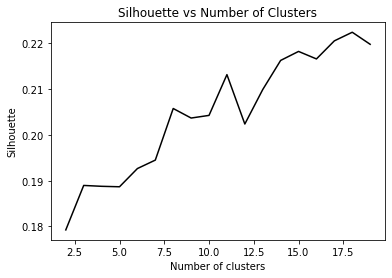

In [92]:
silh = []
llim = 2
ulim = 20
div = 1
x = matrix
for n_clusters in range(llim, ulim, div):
    km = KMeans(n_clusters=n_clusters)
    km.fit(x)
    preds = km.predict(x)
    silh.append(silhouette_score(x, preds, metric='euclidean'))
    
plt.plot(range(llim, ulim, div), silh, 'k')
plt.title("Silhouette vs Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette");

There is no indication of the right number of clusters from the silhoutte score. This seems to be because of the overlap of research topics between articles. After all, many topics in astrophysics are closely related and we might be witnessing a manifestation of that. 

In [5]:
research_areas = list(itertools.chain.from_iterable(research_areas))
most_popular_areas = {key:value for key,value in sorted(Counter(research_areas).items(),reverse=True,key = lambda item:item[1])}

In [6]:
keys = []
values = []
for key,value in most_popular_areas.items():
    keys.append(key)
    values.append(most_popular_areas[key])

In [7]:
[re.sub('\s\(.+\)','',k) for k in keys[0:10]]


['Optics',
 'Fluid Dynamics',
 'Atomic Physics',
 'Physics and Society',
 'Computational Physics',
 'Quantum Physics',
 'Biological Physics',
 'General Physics',
 'Chemical Physics',
 'Statistical Mechanics']

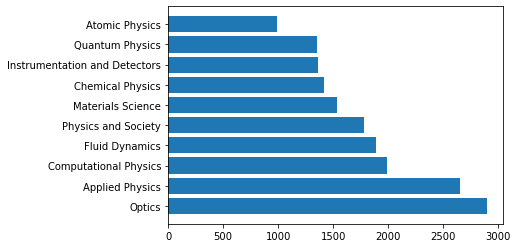

In [57]:
fig = Figure()
axis = fig.add_subplot(1, 1, 1)
axis.barh([re.sub('\s\(.+\)','',k) for k in keys[0:10]],values[0:10])
fig.savefig('2020_important_areas.jpg',bbox_inches='tight')
fig

In [80]:
subfield = ['High Energy Physics - Experiment (hep-ex)',
           'High Energy Physics - Phenomenology (hep-ph)',
             'High Energy Physics - Theory (hep-th)',
            'Cosmology and Nongalactic Astrophysics (astro-ph.CO)']

In [5]:
titles_subfield = []
for i in range(len(titles)):
    research_sub_areas = research_areas[i]
    title = titles[i]
    count = 0
    for area in research_sub_areas:
        if area in subfield and count == 0:
            titles_subfield.append(titles[i])
            count += 1

NameError: name 'subfield' is not defined

In [20]:
stopwords = set(STOPWORDS)
more_stopwords = ['improving','origin','application','Influence','determination','quantification','robustness','calculate','Characteristics','region','generalization','enhance','Implications','creep','impact','predicting','point','zigzag','reconstruction','validation','studies','art','ground','analytic treatment','based simulations','related effects','using','based','effect','system','method',
                 'analysis','model']
for words in more_stopwords:
    stopwords.add(words)

In [68]:
key_words = ''    
for title in titles:
    key_words += ' ' + title 

In [69]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(key_words) 
  


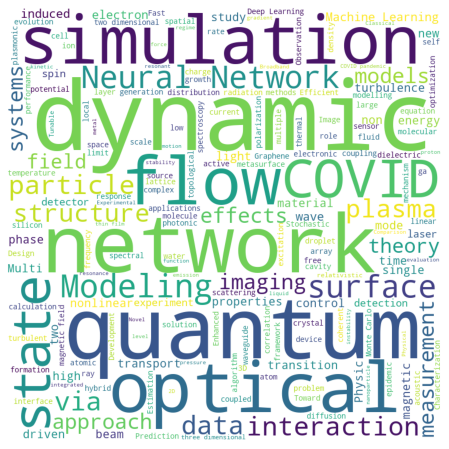

In [35]:
# plot the WordCloud image                        
with PdfPages('2020_cloud.pdf') as pdf:
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    #plt.tight_layout(pad = 0)
    pdf.savefig()

In [70]:
top_word_list = [word for word, score in wordcloud.words_.items()]

In [71]:
top_word_list[0:10]

['dynamic',
 'quantum',
 'network',
 'optical',
 'plasma',
 'theory',
 'state',
 'simulation',
 'electron',
 'particle']

In [23]:
def tokenize_lemma(text):
    #print(text)
    #print([w.lemma_.lower() for w in nlp(text)])
    return [w.lemma_.lower() for w in nlp(text)]

In [24]:
def ngrams_count_func(ngram,corpus_raw,max_features):
    n_grams = CountVectorizer(ngram_range=ngram,
                              stop_words=set(STOPWORDS),
                              tokenizer=tokenize_lemma,
                             max_features=max_features)
    corpus = []
    for text in corpus_raw:
        text_no_comma = re.sub(r'[,:\.\)\(]',' ',text)
        text_no_comma = re.sub(r'  ',' ',text_no_comma)
        text_no_comma = re.sub(r'-','',text_no_comma)
        corpus.append(text_no_comma)
        
    n_grams.fit(corpus)
    X = n_grams.fit_transform(corpus)
    n_gram_count = X.sum(axis=0)
    total_n_grams = X.shape[1]
    n_gram_count_arr = np.zeros(total_n_grams)
    
    for i in range(total_n_grams):
        n_gram_count_arr[i] = n_gram_count.item(0,i)
        
    return n_grams,n_gram_count_arr,X

In [83]:
def top100_func(corpus,alpha):
    
    bigrams,bigram_count_arr,bg = ngrams_count_func(2,corpus,50)
    #unigrams,unigram_count_arr,ug = ngrams_count_func(1,corpus,2)
           
    ratio_arr = np.zeros_like(bigram_count_arr)
    bigram_arr = []
    t0 = time.time()
    i = 0
    for bigram_ents,value in bigrams.vocabulary_.items():
        count_bigram = bigram_count_arr[value]
        pairs = re.findall(r'(.+)\s(.+)',bigram_ents)
        word1 = pairs[0][0]
        word2 = pairs[0][1]
        word1_index = unigrams.vocabulary_[word1]
        word2_index = unigrams.vocabulary_[word2]
        word1_count = unigram_count_arr[word1_index]
        word2_count = unigram_count_arr[word2_index]
        ratio_arr[i] = count_bigram/((word1_count+alpha)*(word2_count+alpha))
        bigram_arr.append(bigram_ents) 
        i += 1
    top100_index = np.argsort(ratio_arr)[::-1][0:100]
    top100 = [bigram_arr[ind] for ind in top100_index]
    
    return top100

In [212]:
bigrams,bigram_count_arr,bigram_arr = ngrams_count_func((2,3),titles,2000)

/Users/saurabh/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/Users/saurabh/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-pron-', 'let', 'must', 'will'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [72]:
def text_clean_func(corpus_raw):
    corpus = []
    for text in corpus_raw:
        text_no_comma = re.sub(r'[,\:\.\)\($\+\"\'\?\/\_\{\}]',' ',text)
        text_no_comma = re.sub(r'  ',' ',text_no_comma)
        text_no_comma = re.sub(r'  ',' ',text_no_comma)
        text_no_comma = re.sub(r'-','',text_no_comma)
        corpus.append(text_no_comma)
    return corpus

In [73]:
titles_clean = text_clean_func(titles)

In [74]:
titles_lemm_list = []
t0 = time.time()
#for i in range(100):
for title in titles_clean:
    #title = titles_clean[i]
    words = title.lower().split()
    title_lemm = [tokenize_lemma(word)[0] for word in words]
    titles_lemm_list.append(' '.join(title_lemm))
time.time()-t0

KeyboardInterrupt: 

In [15]:
dill.dump(titles_lemm_list,open('titles_lemm_list.pkd','wb'))

In [7]:
titles_lemm_list = dill.load(open('titles_lemm_list.pkd', 'rb'))

In [79]:
stopwords = set(STOPWORDS)
more_stopwords = ['-pron-', 'let', 'must', 'will','the']
for words in more_stopwords:
    stopwords.add(words)

In [8]:
stopwords_dict = Counter(stopwords)

In [9]:
t0 = time.time()
titles_no_stop_w_list = []
for title in titles_lemm_list:
#for title in [titles_lemm_list[1]]:
    words = title.split(' ')
    title_no_stop = words.copy()
    for word in words:
        #print(word)
        if stopwords_dict[word]:
            title_no_stop.remove(word)
    titles_no_stop_w_list.append(title_no_stop)
time.time()-t0

0.11127114295959473

In [10]:
titles_final = []
for title in titles_no_stop_w_list:
    titles_final.append(' '.join(title))

In [11]:
titles_no_numbers_list = [re.sub('[\d]+','',title) for title in titles_final]

In [84]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=1000,
                                #tokenizer=tokenize_lemma,
                                ngram_range=(2,3))
                                #stop_words=stopwords)

In [12]:
titles_final = titles_no_numbers_list

In [86]:
tf = tf_vectorizer.fit_transform(titles_final)

In [87]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [88]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [89]:
tf_feature_names = tf_vectorizer.get_feature_names()

In [92]:
print_top_words(lda, tf_feature_names,5)

0 space telescope,planetary system,galactic center,giant planet,active region,
1 star formation,globular cluster,gammaray burst,cosmic ray,molecular cloud,
2 dark energy,galaxy cluster,starforme galaxy,type ia,tidal disruption,
3 milky way,power spectrum,solar system,datum release,spiral galaxy,
4 magnetic field,light curve,active galactic,neural network,galactic nuclei,
5 dwarf galaxy,xray binary,magellanic cloud,stellar population,emission line,
6 fast radio burst,neutron star,white dwarf,
7 star cluster,protoplanetary disk,supernova remnant,gaia dr,solar flare,
8 primordial black hole,dark matter,gravitational wave,
9 spectroscopic survey,weak lense,molecular gas,modify gravity,hot jupiter,



In [791]:
def author_journal_func(response):
    soup = BeautifulSoup(response.text,'lxml')
    authors_full = []
    for line in soup.select("[class = authors]"):
        authors = []
        match = re.findall(r'(<a href.+>)([\w\.\s-]+)(</a>)',str(line))
        for mm in match: authors.append(mm[1])
        authors_full.append(authors)
        
    journals = []
    for line in soup.select("p.comments.is-size-7"):
        match = re.findall(r'(Journal ref:</span>\n)([a-zA-Z\&.\s]+)',str(line))
        for mm in match:
            re_journ_clean = re.sub(' ','',mm[1])
            re_journ_clean = re.sub(r'\.','',re_journ_clean)
            journals.append(re_journ_clean.lower())
    return authors_full,journals

In [792]:
unique_authors_journals = []
session = FuturesSession(max_workers=5)
futures = []
total_papers = 10000
per_page = 200
start_vals = np.arange(0,np.divmod(total_papers,per_page)[0])*per_page
start = time.time()

for vals in start_vals:
    url = f'https://arxiv.org/search/advanced?advanced=&terms-0-operator=AND&terms-0-term=&terms-0-field=all&classification-physics=y&classification-physics_archives=all&classification-include_cross_list=include&date-year=&date-filter_by=date_range&date-from_date=1993-01-01&date-to_date=&date-date_type=announced_date_first&abstracts=hide&size=200&order=announced_date_first&start={vals}'
    futures.append(session.get(url))

for r in [author_journal_func(future.result()) for future in futures]:
    unique_authors_journals.append(r)
end = time.time()
print('Time taken = ', '{:2.2}'.format(end - start))

Time taken =  4.4


In [807]:
unique_authors = []
journal_list = []
for ent in unique_authors_journals:
    unique_authors.append(ent[0])
    journal_list.append(ent[1])
unique_authors = list(itertools.chain.from_iterable(unique_authors))
unique_authors = list(itertools.chain.from_iterable(unique_authors))
journal_list = list(itertools.chain.from_iterable(journal_list))

In [810]:
dill.dump(unique_authors, open('unique_authors.pkd', 'wb'))
dill.dump(journal_list, open('journal_list.pkd', 'wb'))

In [3]:
unique_authors = dill.load(open('unique_authors.pkd', 'rb'))

In [4]:
unique_authors

['Sheldon Katz',
 'P. Marziani',
 'J. W. Sulentic',
 'M. Calvani',
 'E. Perez',
 'M. Moles',
 'M. V. Penston',
 'Scott Dodelson',
 'Jay M. Jubas',
 'M. A. Abramowicz',
 'G. Bao',
 'V. Karas',
 'A. Lanza',
 'Tsvi Piran',
 'Amotz Shemi',
 'Ramesh Narayan',
 'R. Mayle',
 'D. N. Schramm',
 'M. S. Turner',
 'J. Wilson',
 'R. Capuzzo-Dolcetta',
 'P. Mészáros',
 'P. Laguna',
 'M. J. Rees',
 'Peter L. Biermann',
 'J. E. Howe',
 'D. T. Jaffe',
 'E. N. Grossman',
 'W. F. Wall',
 'J. G. Mangum',
 'G. J. Stacey',
 'Joerg P. Rachen',
 'Peter L. Biermann',
 'Andrew H. Jaffe',
 'Albert Stebbins',
 'Joshua A. Frieman',
 'Biman Nath',
 'David Eichler',
 'Ronnie Mainieri',
 'Domingos H. U. Marchetti',
 'Kai T. Hansen',
 'Kai T. Hansen',
 'Kai T. Hansen',
 'Hisao Nakanishi',
 'O. W. Greenberg',
 'N. E. Bonesteel',
 'Jysoo Lee',
 'Didier Poilblanc',
 'Timothy Ziman',
 'Jean Bellissard',
 'Frederic Mila',
 'Gilles Montambaux',
 'Steven C. Erwin',
 'Mark R. Pederson',
 'H. J. Schulz',
 'M. R. Gallis',
 'A. 

In [5]:
unique_authors[0]

'Sheldon Katz'

In [18]:
url = requests.get('https://inspirehep.net/api/authors?sort=bestmatch&size=25&page=1&q=Sheldon%20Katz')
soup = BeautifulSoup(url.text,'html')
soup

<html><body><p>{"hits":{"hits":[{"updated":"2020-09-03T12:29:26.326537+00:00","metadata":{"ids":[{"value":"INSPIRE-00161113","schema":"INSPIRE ID"},{"value":"S.H.Katz.1","schema":"INSPIRE BAI"},{"value":"HEPNAMES-242861","schema":"SPIRES"}],"name":{"value":"Katz, Sheldon H.","preferred_name":"Sheldon H. Katz"},"stub":false,"urls":[{"value":"http://www.math.uiuc.edu/~katz/"},{"value":"http://www.physics.uiuc.edu/people/Katz/index.htm"}],"status":"active","$schema":"https://inspirehep.net/schemas/records/authors.json","deleted":false,"advisors":[{"ids":[{"value":"INSPIRE-00161128","schema":"INSPIRE ID"}],"name":"Gunning, R.C.","degree_type":"other"}],"positions":[{"record":{"$ref":"https://inspirehep.net/api/institutions/908658"},"current":true,"institution":"Illinois U., Urbana, Math. Dept.","curated_relation":true},{"rank":"PHD","record":{"$ref":"https://inspirehep.net/api/institutions/903139"},"end_date":"1980","institution":"Princeton U.","curated_relation":true},{"rank":"UNDERGRADUA

In [10]:
BeautifulSoup?

Init signature:
BeautifulSoup(
    markup='',
    features=None,
    builder=None,
    parse_only=None,
    from_encoding=None,
    exclude_encodings=None,
    element_classes=None,
    **kwargs,
)
Docstring:     
A data structure representing a parsed HTML or XML document.

Most of the methods you'll call on a BeautifulSoup object are inherited from
PageElement or Tag.

Internally, this class defines the basic interface called by the
tree builders when converting an HTML/XML document into a data
structure. The interface abstracts away the differences between
parsers. To write a new tree builder, you'll need to understand
these methods as a whole.

These methods will be called by the BeautifulSoup constructor:
  * reset()
  * feed(markup)

The tree builder may call these methods from its feed() implementation:
  * handle_starttag(name, attrs) # See note about return value
  * handle_endtag(name)
  * handle_data(data) # Appends to the current data node
  * endData(containerClass) # Ends

In [782]:
astro_impact_data = pd.read_csv('scimagojr2019SubjectCategoryAstronomyandAstrophysics.csv', sep=';')
hep_impact_data = pd.read_csv('scimagojr2019SubjectCategoryNuclearandHighEnergyPhysics.csv',sep=';')
misc_impact_data = pd.read_csv('scimagojr2019SubjectCategoryPhysicsandAstronomy(miscellaneous).csv',sep=';')

In [809]:
top_N = Counter(journal_list).most_common(25)
top_N

[('physlettb', 154),
 ('physrevd', 149),
 ('nuclphysb', 73),
 ('physrevlett', 39),
 ('modphysletta', 30),
 ('intjmodphysa', 21),
 ('classquantgrav', 19),
 ('astrophysj', 14),
 ('jphysa', 14),
 ('zphysc', 14),
 ('physrevb', 13),
 ('communmathphys', 13),
 ('annalsphys', 12),
 ('physrevc', 12),
 ('nuclphysa', 11),
 ('jmathphys', 7),
 ('lettmathphys', 7),
 ('astronastrophys', 4),
 ('nuclphysprocsuppl', 4),
 ('physreve', 4),
 ('intjmodphysd', 3),
 ('intjmodphyse', 3),
 ('physrept', 3),
 ('annrevnuclpartsci', 3),
 ('jstatistphys', 2)]

In [64]:
journal_name_dict = {'physrevd':'Physical Review D',
 'physlettb':'Physics Letter B',
 'nuclphysb':'Nuclear Physics B',
 'physrevlett':'Physical Review Letters',
 'modphysletta':'Modern Physics Letters A',
 'astrophysj':'Astrophysical Journal',
 'intjmodphysa':'International Journal of Modern Physics A',
 'classquantgrav':'Classical and Quantum Gravity',
 'zphysc':'Zeitschrift für Physik C Particles and Fields',
 'physrevc':'Physical Review C',
 'nuclphysprocsuppl':'Nuclear Physics Proceedings Supplement',
 'jmathphys':'Journal of Mathematical Physics',
 'communmathphys':'Communications in Mathematical Physics',
 'jphysa':'Journal of Physics A',
 'physrevb':'Physical Review B',
 'nuclphysa':'Nuclear Physics A',
 'progtheorphys':'Progress in Theoretical Physics',
 'lettmathphys':'Letters in Mathematical Physics',
 'monnotroyastronsoc':'Monthly Notices of Royal Astronomical Society',
 'annalsphys':'Annals of Physics',
 'intjmodphysd':'International Journal of Modern Physics D',
 'physreve':'Physical Review E',
 'astronastrophys':'Astronomy and Astrophysics',
 'physletta':'Physics Letters A',
 'jgeomphys':'Journal of Geometry and Physics'}

In [57]:
journal_cols = ['Journal','Total papers published']
journal = pd.DataFrame(columns = journal_cols)
journal_list = []
count_list = []
for j, c in top_N:
    journal_list += [j]
    count_list += [c]
journal['Journal'] = journal_list
journal['Total papers published'] = count_list
journal.to_csv('journal.csv', header=list(journal.columns.values), index=None, sep=',')

In [244]:
journal_impact_dict = defaultdict(float)
journal_impact_dict['astrophysj']= 2.144
journal_impact_dict['physrevd']= 1.664
journal_impact_dict['monnotroyastronsoc']= 1.937
journal_impact_dict['physlettb']= 1.795
journal_impact_dict['astronastrophys']= 2.174
journal_impact_dict['physrevlett']= 3.588
journal_impact_dict['astronj']= 2.374
journal_impact_dict['nuclphysb']= 1.081
journal_impact_dict['classquantgrav']= 1.365
journal_impact_dict['intjmodphysd']= 0.75
journal_impact_dict['modphysletta']= 0.469
journal_impact_dict['astropartphys']= 1.143
journal_impact_dict['astrophysjsuppl']= 3.335
journal_impact_dict['intjmodphysa']= 0.51
journal_impact_dict['intjmodphysc']= 0.28
journal_impact_dict['publastronsocjap']= 1.594
journal_impact_dict['physletta']= 0.51
journal_impact_dict['mnras']= 1.937
journal_impact_dict['jcap']= 0.813
journal_impact_dict['nuclphysa']= 0.614
journal_impact_dict['jphysg']=1.299
journal_impact_dict['jhep']=0.948
journal_impact_dict['intjmodphysd']=0.75

In [22]:
top_authors = Counter(unique_authors).most_common(100000)
len(top_authors)

10713

In [21]:
author_cols = ['author']
author = pd.DataFrame(columns = author_cols)
author_list = []
#count_list = []
for j, c in top_authors:
    author_list += [j]
#    count_list += [c]
author['author'] = author_list
#author['Total papers published'] = count_list
author.to_csv('author.csv', header=list(author.columns.values), index=None, sep=',')

In [247]:
url

'https://export.arxiv.org/find/grp_physics/1/au:+wu_yue/0/1/0/all/0/1?per_page=227'

In [518]:
def author_details_func(response):
    soup = BeautifulSoup(response.text,'lxml')
    authors_full = []
    for line in soup.select("[class = list-authors]"):
        authors = []
        match = re.findall(r'(<a href.+>)([\w\.\s-]+)(</a>)',str(line))
        for mm in match: authors.append(mm[1])
        authors_full.append(authors)

    year = []
    for line in soup.select("[class = list-identifier]"):
        match = re.search(r'\d\d\d\d',str(line))
        if match:
            string = match.group()
            re_year = re.search(r'\d\d',string)
            if int(re_year.group()) > 20:
                year.append('19'+re_year.group())
            else:
                year.append('20'+re_year.group())

    journals = []
    for line in soup.select("[class = meta]"):
        match = re.findall(r'(Journal-ref:</span>)([a-zA-Z\&.\s]+)',str(line))
        if match:
            for mm in match:
                re_journ_clean = re.sub(' ','',mm[1])
                re_journ_clean = re.sub(r'\.','',re_journ_clean)
                journals.append(re_journ_clean.lower())
        else:
            journals.append(' ')
        
    return authors_full, year, journals

In [544]:
result=[]

In [545]:
N1 = 0

In [472]:
result = dill.load(open('result.pkd', 'rb'))

In [666]:
start = time.time()

session = FuturesSession(max_workers=5)
futures = []
N0 = N1
N1 = N0 + 1000
for author_ind in range(N0,N1):
    name = author_list[author_ind]
    name = name.casefold()
    name = unidecode.unidecode(name)
    first_name = re.search(r'^\w+',name).group()
    last_name = re.search(r'\S+$',name).group()    
    url = f'https://export.arxiv.org/find/grp_physics/1/au:+{last_name}_{first_name}/0/1/0/all/0/1?per_page=200'
    futures.append(session.get(url))

for r in [author_details_func(future.result()) for future in futures]:
    result.append(r)
end = time.time()
print('Time taken = ', '{:2.2}'.format(end - start))

Time taken =  3.8e+02


In [668]:
list_impact_per_year = []
list_papers_per_year = []

for author_ind in range(0,N1):
    name = author_list[author_ind]
    year = result[author_ind][1]
    journal = result[author_ind][2]

    pubs_per_year_dict = {key:value for key,value in sorted(Counter(year).items(), reverse=True)}
    list_papers_per_year.append(pubs_per_year_dict)
    
    j = 0
    impact_per_year_dict = {}
    for key in pubs_per_year_dict.keys():
        k = 0
        for i in range(pubs_per_year_dict[key]):
            journal_name = journal[j]
            j += 1
            k += journal_impact_dict[journal_name]
        impact_per_year_dict[key] = k
    list_impact_per_year.append(impact_per_year_dict)

In [818]:
dill.dump(result, open('result.pkd', 'wb'))

TypeError: write() argument must be str, not bytes

In [689]:
academic = []
non_academic = []
for author_ind in range(0,N1):
    papers_per_year = list_papers_per_year[author_ind]
    impact_per_year = list_impact_per_year[author_ind]
    if len(papers_per_year) >= 10:
        start = int(min(papers_per_year.keys()))
        end = start + 5
        total_pubs = 0
        total_imp = 0
        for y in range(start,end+1):
            if str(y) in papers_per_year.keys():
                total_pubs += papers_per_year[str(y)]
                total_imp += impact_per_year[str(y)]
        academic.append([total_pubs,total_imp])
    elif(0 < len(papers_per_year) < 10 ):
        start = int(min(papers_per_year.keys()))
        end = min(int(max(papers_per_year.keys())),start + 5)
        total_pubs = 0
        total_imp = 0
        for y in range(start,end+1):
            if str(y) in papers_per_year.keys():
                total_pubs += papers_per_year[str(y)]
                total_imp += impact_per_year[str(y)]
        non_academic.append([total_pubs,total_imp])

In [814]:
non_academic_cut = []
index = 1
for ent in non_academic:
    if ent[index] < 20:
        non_academic_cut.append(ent[index]) 
academic_cut = []
for ent in academic:
    if ent[index] < 20:
        academic_cut.append(ent[index]) 

In [703]:
print(percentile(academic_cut,[25,50,75]),percentile(non_academic_cut,[25,50,75]))

[10. 13. 17.] [ 5.  7. 11.]


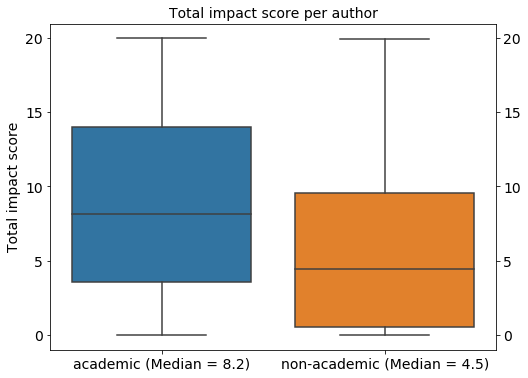

In [815]:
with PdfPages('total_impact_box.pdf') as pdf:
    fig= plt.figure(figsize=(8,6))
    ax = sns.boxplot(data=[academic_cut,non_academic_cut])
    ax.tick_params(labelsize=14,labelright=True,right=True)
    ax.set_yticks(np.arange(0,25,5))
    ax.set_title('Total impact score per author',fontsize=14)
    ax.set_xticklabels([f'academic (Median = {np.round(percentile(academic_cut,[25,50,75])[1],1)})',f'non-academic (Median = {np.round(percentile(non_academic_cut,[25,50,75])[1],1)})'],fontsize=14)
    ax.set_ylabel('Total impact score',fontsize=14)
    pdf.savefig();

In [6]:
url

'https://export.arxiv.org/list/physics.optics/00?abs=true&skip=0&show=200'

In [40]:
dill.dump(title_research_area,open('2010_title_research_area.pkd','wb'))

In [64]:
title_research_area = dill.load(open('2010_title_research_area.pkd', 'rb'))

In [65]:
research_areas = []
titles = []
for ent in title_research_area:
    for title in ent[0]:
        titles.append(title)
    for area in ent[1]:
        research_areas.append(area)

In [66]:
len(titles)

7402

In [67]:
research_areas = list(itertools.chain.from_iterable(research_areas))
most_popular_areas = {key:value for key,value in sorted(Counter(research_areas).items(),reverse=True,key = lambda item:item[1])}

In [45]:
most_popular_areas

{'Optics (physics.optics)': 1224,
 'Fluid Dynamics (physics.flu-dyn)': 797,
 'Atomic Physics (physics.atom-ph)': 766,
 'Physics and Society (physics.soc-ph)': 687,
 'Computational Physics (physics.comp-ph)': 676,
 'Quantum Physics (quant-ph)': 659,
 'Biological Physics (physics.bio-ph)': 613,
 'General Physics (physics.gen-ph)': 585,
 'Chemical Physics (physics.chem-ph)': 526,
 'Statistical Mechanics (cond-mat.stat-mech)': 514,
 'Plasma Physics (physics.plasm-ph)': 512,
 'Instrumentation and Detectors (physics.ins-det)': 501,
 'Data Analysis, Statistics and Probability (physics.data-an)': 427,
 'Soft Condensed Matter (cond-mat.soft)': 354,
 'Classical Physics (physics.class-ph)': 352,
 'Materials Science (cond-mat.mtrl-sci)': 344,
 'Mathematical Physics (math-ph)': 265,
 'Mesoscale and Nanoscale Physics (cond-mat.mes-hall)': 255,
 'High Energy Physics - Experiment (hep-ex)': 243,
 'Geophysics (physics.geo-ph)': 228,
 'Atmospheric and Oceanic Physics (physics.ao-ph)': 185,
 'Space Physi

In [54]:
keys = []
values = []
for key,value in most_popular_areas.items():
    keys.append(key)
    values.append(most_popular_areas[key])

In [55]:
[re.sub('\s\(.+\)','',k) for k in keys[0:10]]


['Optics',
 'Applied Physics',
 'Computational Physics',
 'Fluid Dynamics',
 'Physics and Society',
 'Materials Science',
 'Chemical Physics',
 'Instrumentation and Detectors',
 'Quantum Physics',
 'Atomic Physics']

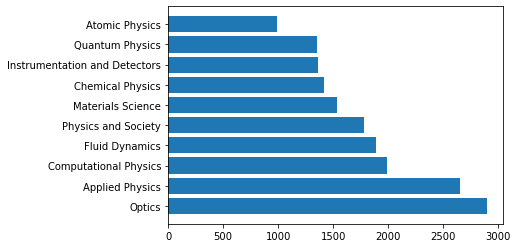

In [57]:
fig = Figure()
axis = fig.add_subplot(1, 1, 1)
axis.barh([re.sub('\s\(.+\)','',k) for k in keys[0:10]],values[0:10])
fig.savefig('2020_important_areas.jpg',bbox_inches='tight')
fig

In [80]:
subfield = ['High Energy Physics - Experiment (hep-ex)',
           'High Energy Physics - Phenomenology (hep-ph)',
             'High Energy Physics - Theory (hep-th)',
            'Cosmology and Nongalactic Astrophysics (astro-ph.CO)']

In [5]:
titles_subfield = []
for i in range(len(titles)):
    research_sub_areas = research_areas[i]
    title = titles[i]
    count = 0
    for area in research_sub_areas:
        if area in subfield and count == 0:
            titles_subfield.append(titles[i])
            count += 1

NameError: name 'subfield' is not defined

In [20]:
stopwords = set(STOPWORDS)
more_stopwords = ['improving','origin','application','Influence','determination','quantification','robustness','calculate','Characteristics','region','generalization','enhance','Implications','creep','impact','predicting','point','zigzag','reconstruction','validation','studies','art','ground','analytic treatment','based simulations','related effects','using','based','effect','system','method',
                 'analysis','model']
for words in more_stopwords:
    stopwords.add(words)

In [116]:
key_words = ''    
for title in titles:
    key_words += ' ' + title 

In [117]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(key_words) 
  


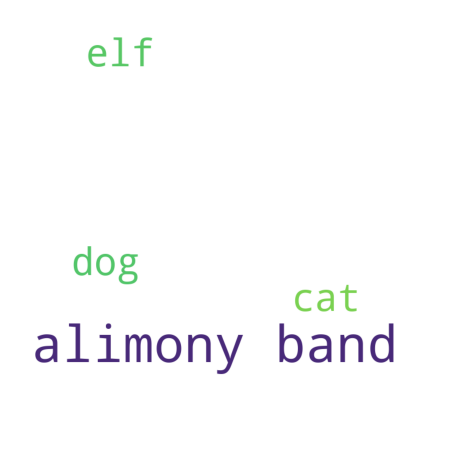

In [147]:
# plot the WordCloud image                        
with PdfPages('temp.pdf') as pdf:
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    #plt.tight_layout(pad = 0)
    pdf.savefig()

In [70]:
top_word_list = [word for word, score in wordcloud.words_.items()]

In [71]:
top_word_list[0:10]

['dynamic',
 'quantum',
 'network',
 'optical',
 'plasma',
 'theory',
 'state',
 'simulation',
 'electron',
 'particle']

In [23]:
def tokenize_lemma(text):
    #print(text)
    #print([w.lemma_.lower() for w in nlp(text)])
    return [w.lemma_.lower() for w in nlp(text)]

In [24]:
def ngrams_count_func(ngram,corpus_raw,max_features):
    n_grams = CountVectorizer(ngram_range=ngram,
                              stop_words=set(STOPWORDS),
                              tokenizer=tokenize_lemma,
                             max_features=max_features)
    corpus = []
    for text in corpus_raw:
        text_no_comma = re.sub(r'[,:\.\)\(]',' ',text)
        text_no_comma = re.sub(r'  ',' ',text_no_comma)
        text_no_comma = re.sub(r'-','',text_no_comma)
        corpus.append(text_no_comma)
        
    n_grams.fit(corpus)
    X = n_grams.fit_transform(corpus)
    n_gram_count = X.sum(axis=0)
    total_n_grams = X.shape[1]
    n_gram_count_arr = np.zeros(total_n_grams)
    
    for i in range(total_n_grams):
        n_gram_count_arr[i] = n_gram_count.item(0,i)
        
    return n_grams,n_gram_count_arr,X

In [83]:
def top100_func(corpus,alpha):
    
    bigrams,bigram_count_arr,bg = ngrams_count_func(2,corpus,50)
    #unigrams,unigram_count_arr,ug = ngrams_count_func(1,corpus,2)
           
    ratio_arr = np.zeros_like(bigram_count_arr)
    bigram_arr = []
    t0 = time.time()
    i = 0
    for bigram_ents,value in bigrams.vocabulary_.items():
        count_bigram = bigram_count_arr[value]
        pairs = re.findall(r'(.+)\s(.+)',bigram_ents)
        word1 = pairs[0][0]
        word2 = pairs[0][1]
        word1_index = unigrams.vocabulary_[word1]
        word2_index = unigrams.vocabulary_[word2]
        word1_count = unigram_count_arr[word1_index]
        word2_count = unigram_count_arr[word2_index]
        ratio_arr[i] = count_bigram/((word1_count+alpha)*(word2_count+alpha))
        bigram_arr.append(bigram_ents) 
        i += 1
    top100_index = np.argsort(ratio_arr)[::-1][0:100]
    top100 = [bigram_arr[ind] for ind in top100_index]
    
    return top100

In [84]:
top100 = top100_func([titles[0]],30)

/Users/saurabh/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


until
['until']
let's
['let', '-pron-']
through
['through']
so
['so']
here
['here']
are
['be']
by
['by']
who
['who']
any
['any']
why
['why']
didn't
['do', 'not']
into
['into']
since
['since']
haven't
['have', 'not']
a
['a']
because
['because']
ever
['ever']
you're
['-pron-', 'be']
cannot
['can', 'not']
for
['for']
where
['where']
an
['an']
having
['have']
has
['have']
it's
['-pron-', 'be']
when
['when']
he'd
['-pron-', 'would']
than
['than']
mustn't
['must', 'not']
would
['would']
shan't
['shall', 'not']
her
['-pron-']
else
['else']
hence
['hence']
once
['once']
myself
['-pron-']
these
['these']
to
['to']
weren't
['be', 'not']
i
['i']
wouldn't
['would', 'not']
after
['after']
otherwise
['otherwise']
we're
['-pron-', 'be']
out
['out']
further
['further']
how
['how']
with
['with']
couldn't
['could', 'not']
off
['off']
where's
['where', 'be']
again
['again']
k
['k']
what's
['what', 'be']
hasn't
['have', 'not']
on
['on']
theirs
['-pron-']
just
['just']
your
['-pron-']
those
['those']
other

/Users/saurabh/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-pron-', 'let', 'must', 'will'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


NameError: name 'unigrams' is not defined

In [37]:
top100

['der waals',
 'van der',
 'ab initio',
 'sars cov',
 'kohn sham',
 'discontinuous galerkin',
 'fabry perot',
 'monte carlo',
 'rayleigh bénard',
 'fokker planck',
 'hartree fock',
 'whispering gallery',
 'hele shaw',
 'coarse grained',
 'least squares',
 'cahn hilliard',
 'ou mandel',
 'navier stokes',
 'generative adversarial',
 'hong ou',
 'bethe salpeter',
 'polycyclic aromatic',
 'lithium niobate',
 'exceptional points',
 'permanent magnet',
 'herd immunity',
 'von neumann',
 'hl lhc',
 'additive manufacturing',
 'pharmaceutical interventions',
 'siw ecal',
 'aharonov bohm',
 'bose einstein',
 'emitting diodes',
 'input output',
 'geomagnetic storms',
 'boron nitride',
 'hexagonal boron',
 'refractive index',
 'figure merit',
 'wisdom crowds',
 'inner heliosphere',
 'front end',
 'artificial intelligence',
 'decision making',
 'halide perovskites',
 'projection chamber',
 'fourier transform',
 'prisoner dilemma',
 'aromatic hydrocarbons',
 'mach zehnder',
 'spatio temporal',
 'rey

In [212]:
bigrams,bigram_count_arr,bigram_arr = ngrams_count_func((2,3),titles,2000)

/Users/saurabh/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/Users/saurabh/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-pron-', 'let', 'must', 'will'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


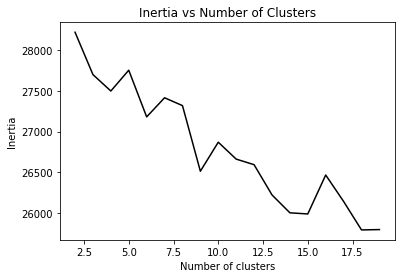

In [213]:
inertias = []
llim = 2
ulim = 20
for n_clusters in range(llim, ulim):
    km = KMeans(n_clusters=n_clusters).fit(bigram_arr.toarray())
    inertias.append(km.inertia_)
    
plt.plot(range(llim, ulim), inertias, 'k')
plt.title("Inertia vs Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia");

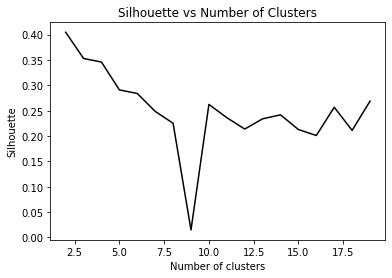

In [214]:
silh = []
llim = 2
ulim = 20
div = 1
x = bigram_arr.toarray()
for n_clusters in range(llim, ulim, div):
    km = KMeans(n_clusters=n_clusters)
    km.fit(x)
    preds = km.predict(x)
    silh.append(silhouette_score(x, preds, metric='euclidean'))
    
plt.plot(range(llim, ulim, div), silh, 'k')
plt.title("Silhouette vs Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette");

In [72]:
def text_clean_func(corpus_raw):
    corpus = []
    for text in corpus_raw:
        text_no_comma = re.sub(r'[,\:\.\)\($\+\"\'\?\/\_\{\}]',' ',text)
        text_no_comma = re.sub(r'  ',' ',text_no_comma)
        text_no_comma = re.sub(r'  ',' ',text_no_comma)
        text_no_comma = re.sub(r'-','',text_no_comma)
        corpus.append(text_no_comma)
    return corpus

In [73]:
titles_clean = text_clean_func(titles)

In [74]:
titles_lemm_list = []
t0 = time.time()
#for i in range(100):
for title in titles_clean:
    #title = titles_clean[i]
    words = title.lower().split()
    title_lemm = [tokenize_lemma(word)[0] for word in words]
    titles_lemm_list.append(' '.join(title_lemm))
time.time()-t0

KeyboardInterrupt: 

In [15]:
dill.dump(titles_lemm_list,open('titles_lemm_list.pkd','wb'))

In [31]:
titles_lemm_list = dill.load(open('titles_lemm_list.pkd', 'rb'))

In [93]:
len(titles_lemm_list)

13600

In [32]:
titles_lemm_list[0:10]

['connect optical morphology environment and hi mass fraction for lowredshift galaxy use deep learn',
 'over 78 000 rr lyrae star in the galactic bulge and disk from the ogle survey',
 'highresolution spectra and biosignature of earthlike planet transit white dwarfs',
 'high resolution spectra of earthlike planet orbit red giant host star',
 'deflate superpuff impact of photochemical haze on the observe massradius relationship of low mass planet',
 'how surface shape the climate of habitable exoplanet',
 'creation and evolution of impactgenerate reduce atmosphere of early earth',
 'galaxy host an agn a view from the califa survey',
 'size and shape constraint of 486958 arrokoth from stellar occultation',
 'clumpy agn outflow due to thermal instability']

In [34]:
stopwords = set(STOPWORDS)
more_stopwords = ['-pron-', 'let', 'must', 'will','the']
for words in more_stopwords:
    stopwords.add(words)

In [35]:
stopwords_dict = Counter(stopwords)

In [36]:
t0 = time.time()
titles_no_stop_w_list = []
for title in titles_lemm_list:
#for title in [titles_lemm_list[1]]:
    words = title.split(' ')
    title_no_stop = words.copy()
    for word in words:
        #print(word)
        if stopwords_dict[word]:
            title_no_stop.remove(word)
    titles_no_stop_w_list.append(title_no_stop)
time.time()-t0

0.09728169441223145

In [37]:
titles_final = []
for title in titles_no_stop_w_list:
    titles_final.append(' '.join(title))

In [38]:
titles_no_numbers_list = [re.sub('[\d]+','',title) for title in titles_final]

In [40]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=1000,
                                #tokenizer=tokenize_lemma,
                                ngram_range=(2,3))
                                #stop_words=stopwords)

In [39]:
titles_final = titles_no_numbers_list

In [48]:
titles_final[0]

'connect optical morphology environment hi mass fraction lowredshift galaxy use deep learn'

In [41]:
tf = tf_vectorizer.fit_transform(titles_final)

In [42]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [43]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [44]:
tf_feature_names = tf_vectorizer.get_feature_names()

In [47]:
print_top_words(lda, tf_feature_names,5)

0 space telescope,planetary system,galactic center,giant planet,active region,
1 star formation,globular cluster,gammaray burst,cosmic ray,molecular cloud,
2 dark energy,galaxy cluster,starforme galaxy,type ia,tidal disruption,
3 milky way,power spectrum,solar system,datum release,spiral galaxy,
4 magnetic field,light curve,active galactic,neural network,galactic nuclei,
5 dwarf galaxy,xray binary,magellanic cloud,stellar population,emission line,
6 fast radio burst,neutron star,white dwarf,
7 star cluster,protoplanetary disk,supernova remnant,gaia dr,solar flare,
8 primordial black hole,dark matter,gravitational wave,
9 spectroscopic survey,weak lense,molecular gas,modify gravity,hot jupiter,



In [55]:
lda.components_

array([[14.98035035,  0.10001188, 10.03408227, ..., 16.13212733,
         0.10000663,  0.10000853],
       [ 0.10000594,  0.1000098 ,  0.10000939, ...,  0.10000833,
         0.1000109 ,  0.10000967],
       [ 0.10000635,  0.10002457,  0.10000619, ...,  0.10000783,
         0.10000645,  0.100005  ],
       ...,
       [ 0.10000526,  9.84598778,  0.10000837, ...,  0.10000602,
         0.10000687,  0.10000658],
       [ 0.10000619,  0.10001702,  0.1000368 , ...,  0.10000605,
         0.10000648,  0.10000716],
       [ 0.10000974,  0.10001804,  0.10000676, ...,  0.10000756,
         0.10000689,  0.10000511]])

In [46]:
def print_top_words(model, feature_names, n_top_words=20):
    model_components = model.components_
    for topic_idx, topic in enumerate(model_components):
        message = "Topic #%d: " % topic_idx
        message += ",".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        bigram_clean_str = ''
        message_clean = ''
        unigram_clean_list = []
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            word = feature_names[i]
            #print(word)
            if re.search(r'[\w]+\s[\w]+\s[\w]+', word):
                bigram_clean_str += word + ' '
                message_clean += word + ','
            else:
                unigram_clean_list.append(word)

        for word in unigram_clean_list:
            if word not in bigram_clean_str:
                message_clean += word + ','
        print(topic_idx, message_clean)
        #print(message)
    print()

In [60]:
def vocab_bi_tri(list_of_words):
    trigram_clean_str = ''
    vocab_clean = ''
    bigram_clean_list = []
    for word in list_of_words:
        #print(word)
        if re.search(r'[\w]+\s[\w]+\s[\w]+', word):
            trigram_clean_str += word + ' '
            vocab_clean += word + ','
        else:
            bigram_clean_list.append(word)

    for word in bigram_clean_list:
        if word not in trigram_clean_str:
            vocab_clean += word + ','
    return [vocab_clean.split(',')]        
    #print(topic_idx, message_clean)
    #print(message)


In [271]:
bi_tri = vocab_bi_tri(tf_feature_names)
bi_tri_dict = Counter(bi_tri[0])

In [272]:
titles_unigram = []   

for title in titles_final:
    unis = title.split()
    title_new = title
    for i in range(len(unis)-2):
        phrase = unis[i]+' ' +unis[i+1]+' '+unis[i+2]
        #print(phrase)
        if bi_tri_dict[phrase]:
            title_new = re.sub(phrase,'',title_new)
    unis = title_new.split()
    unis_len = len(unis)
    for i in range(unis_len-1):
        phrase = unis[i]+' ' +unis[i+1]
        if bi_tri_dict[phrase]:
            title_new = re.sub(phrase,'',title_new)
    titles_unigram.append(title_new)                

In [273]:
unigram_list = [word for title in titles_unigram for word in title.split()]

In [274]:
unigram_dict = Counter(unigram_list)

In [275]:
unigram_sort = [key for key in sorted(unigram_dict.keys())]
bi_tri_sort = [key for key in sorted(bi_tri_dict.keys())]

In [293]:
word_vect_index = defaultdict(int)
i = 1
for phrase in bi_tri_sort:
    word_vect_index[phrase] = i
    i += 1 
for word in unigram_sort:
    word_vect_index[word] = i
    i += 1

In [285]:
    
def word_order2(index,unis,title_new,word):
    #print(word.split())
    #title_new.append(index)
    #phrase = ' '.join(word.split())
    #unis_join = ' '.join(unis)
    #unis_join = re.sub(phrase,'',unis_join)
    #unis = unis_join.split()
    for w in word.split():
        unis.remove(w)
    return unis,title_new

In [277]:
    
def word_order(index,unis,title_new,word):
    #print(word.split())
    title_new.append(index)
    #phrase = ' '.join(word.split())
    #unis_join = ' '.join(unis)
    #unis_join = re.sub(phrase,'',unis_join)
    #unis = unis_join.split()
    for w in word.split():
        unis.remove(w)
    return unis,title_new

In [294]:
titles_to_vec = []   
i = 0
t0 = time.time()
for title in titles_final:
#for title in [titles_final[i]]:
    print(title,i)
    unis = title.split()
    title_new = []
    #i = 11
    title_in_unigram = titles_unigram[i].split()

    try:
        while unis:
            #print(unis,title_in_unigram)
            word = unis[0]
            if len(title_in_unigram) > 0 and len(unis) > 0:
                if word == title_in_unigram[0]:
                    index = word_vect_index[word]
                    unis,title_new = word_order2(index,unis,title_new,word)
                    title_in_unigram.remove(word)
                else:
                    word = unis[0] + ' ' + unis[1]
                    index = word_vect_index[word]
                    if index:
                        unis,title_new = word_order(index,unis,title_new,word)
                    else:
                        word = unis[0] + ' ' + unis[1] + ' ' + unis[2]
                        index = word_vect_index[word]
                        unis,title_new = word_order(index,unis,title_new,word)
            elif len(title_in_unigram) == 0 and len(unis) > 0:
                word = unis[0] + ' ' + unis[1]
                index = word_vect_index[word]
                if index:
                    unis,title_new = word_order(index,unis,title_new,word)
                else:
                    word = unis[0] + ' ' + unis[1] + ' ' + unis[2]
                    index = word_vect_index[word]
                    unis,title_new = word_order(index,unis,title_new,word)

        i += 1           
        titles_to_vec.append(title_new)  
    except:
        i += 1
time.time()-t0

connect optical morphology environment hi mass fraction lowredshift galaxy use deep learn 0
  rr lyrae star galactic bulge disk ogle survey 1
highresolution spectra biosignature earthlike planet transit white dwarfs 2
high resolution spectra earthlike planet orbit red giant host star 3
deflate superpuff impact photochemical haze observe massradius relationship low mass planet 4
surface shape climate habitable exoplanet 5
creation evolution impactgenerate reduce atmosphere early earth 6
galaxy host agn view califa survey 7
size shape constraint  arrokoth stellar occultation 8
clumpy agn outflow due thermal instability 9
evidence planetary hypothesis ptfo b fiveyear optical infrare monitoring observation 10
gasdust correlation nearby galaxy case study ngc  ngc  11
wave reflection transmission interface convective stably stratify region rotate star planet 12
edge signal presence magnetic field 13
determine formation characteristic protoplanetary discs 14
gravitationalwave memory propagati

6.277889013290405

In [301]:
for title in titles_to_vec:
    if title == []: title.append(0)

In [307]:
vocab.insert(0,' ')

In [281]:
vocab = [key for key,value in sorted(word_vect_index.items(),
                                    key = lambda item: item[1])]

In [310]:
vocab = bi_tri_sort
hlda = HierarchicalLDA(titles_to_vec, vocab,num_levels=3)

In [5]:
hlda = HierarchicalLDA()
hlda.estimate?

TypeError: __init__() missing 2 required positional arguments: 'corpus' and 'vocab'

In [311]:
n_samples = 5
hlda.estimate(n_samples, display_topics=10, n_words=5, with_weights=False)

HierarchicalLDA sampling
.....

In [312]:
hlda.print_nodes(5,False)

topic 0 (level=0, total_words=6337, documents=13592):  , primordial black hole, light curve, cosmic ray, protoplanetary disk, 
    topic 1 (level=1, total_words=297, documents=795):  , quark star, starforme galaxy, protoplanetary disk, alma observation, 
        topic 2 (level=2, total_words=1, documents=4): line emission, zwicky transient facility, galactic outflow, galaxy ii, galaxy group, 
        topic 16 (level=2, total_words=3, documents=15): massive neutrino, modify gravity, transmission spectra, zwicky transient facility, galaxy group, 
        topic 28 (level=2, total_words=3, documents=10): disc wind, magnetic reconnection, cosmological perturbation, zwicky transient facility, galaxy mass assembly, 
        topic 35 (level=2, total_words=4, documents=9): hot jupiter, supernova remnant, gas mass, massive galaxy, galactic outflow, 
        topic 36 (level=2, total_words=11, documents=15): datum analysis, soft xray, physical parameter, milky way satellite, cosmic string, 
      

In [313]:
colour_map = {
    0: 'blue',
    1: 'red',
    2: 'green'
}

def show_doc(d=0):
    
    node = hlda.document_leaves[d]
    path = []
    while node is not None:
        path.append(node)
        node = node.parent
    path.reverse()   
    
    n_words = 10
    with_weights = False    
    for n in range(len(path)):
        node = path[n]
        colour = colour_map[n] 
        msg = 'Level %d Topic %d: ' % (node.level, node.node_id)
        msg += node.get_top_words(n_words, with_weights)
        output = '<h%d><span style="color:%s">%s</span></h3>' % (n+1, colour, msg)
        display(HTML(output))
        
    display(HTML('<hr/><h5>Processed Document</h5>'))

    doc = corpus[d]
    output = ''
    for n in range(len(doc)):
        w = doc[n]
        l = hlda.levels[d][n]
        colour = colour_map[l]
        output += '<span style="color:%s">%s</span> ' % (colour, w)
    display(HTML(output))

In [315]:
from ipywidgets import widgets
from IPython.core.display import HTML, display


In [316]:
widgets.interact(show_doc, d=(0, len(titles_to_vec)-1))

IndexError: index 2 is out of bounds for axis 0 with size 2

<function __main__.show_doc(d=0)>

In [351]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
G = nx.DiGraph()


In [352]:
G.add_node("ROOT")


In [353]:
for i in range(5):
    G.add_node("Child_%i" % i)
    G.add_node("Grandchild_%i" % i)
    G.add_node("Greatgrandchild_%i" % i)

    G.add_edge("ROOT", "Child_%i" % i)
    G.add_edge("Child_%i" % i, "Grandchild_%i" % i)
    G.add_edge("Grandchild_%i" % i, "Greatgrandchild_%i" % i)

# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"

In [354]:
! dot -Tpng test.dot >test.png

In [355]:
nx.nx_agraph.write_dot(G,'test.dot')

# same layout using matplotlib with no labels
plt.title('draw_networkx')
pos=graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, arrows=False)
plt.savefig('nx_test.png')

RuntimeError: generator raised StopIteration

In [220]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import glob


In [221]:
stopset = stopwords.words('english') + list(string.punctuation) + ['will', 'also', 'said']


In [222]:
corpus = []
all_docs = []
vocab = set()

stemmer = PorterStemmer()
for filename in glob.glob('./tech/*.txt'):
    with open(filename) as f:
        try:
            
            doc = f.read().splitlines() 
            doc = filter(None, doc) # remove empty string
            doc = '. '.join(doc)
            doc = doc.translate(string.punctuation) # strip punctuations
            doc = doc.translate('0123456789') # strip numbers        
            #doc = doc.decode("utf8").encode('ascii', 'ignore') # ignore fancy unicode chars
            all_docs.append(doc)        

            tokens = word_tokenize(str(doc))
            filtered = []
            for w in tokens:
                w = stemmer.stem(w.lower()) # use Porter's stemmer
                if len(w) < 3:              # remove short tokens
                    continue
                if w in stopset:            # remove stop words
                    continue
                filtered.append(w)
                
            vocab.update(filtered)
            corpus.append(filtered)      
            
        except UnicodeDecodeError:
            print ('Failed to load'), filename

In [223]:

vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i

In [224]:
new_corpus = []
for doc in corpus:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)

In [229]:
from hlda.sampler import HierarchicalLDA


In [230]:
hlda = HierarchicalLDA(new_corpus, vocab)


In [314]:
from gensim.models import CoherenceModel

ImportError: cannot import name 'open' from 'smart_open' (/Users/saurabh/opt/anaconda3/lib/python3.7/site-packages/smart_open/__init__.py)

In [114]:
bigrams.vocabulary_

{'connect optical': 3,
 'optical morphology': 16,
 'morphology environment': 14,
 'environment hi': 6,
 'hi mass': 10,
 'mass fraction': 13,
 'fraction lowredshift': 7,
 'lowredshift galaxy': 11,
 'galaxy use': 9,
 'use deep': 19,
 'deep learning': 4,
 '78 000': 1,
 '000 rr': 0,
 'rr lyrae': 17,
 'lyrae star': 12,
 'star galactic': 18,
 'galactic bulge': 8,
 'bulge disk': 2,
 'disk ogle': 5,
 'ogle survey': 15}

In [132]:
from sklearn.cluster import KMeans

In [164]:
km = KMeans(n_clusters=3).fit(bigram_arr.toarray())

In [165]:
centroids = km.cluster_centers_

In [166]:
index = np.argsort(centroids[0])[::-1][0:24]
[bigrams.get_feature_names()[i] for i in index]

['dark matter',
 'neutron star',
 'gravitational wave',
 'magnetic field',
 'star formation',
 'milky way',
 'dark energy',
 'globular cluster',
 'radio burst',
 'galaxy cluster',
 'white dwarf',
 'fast radio',
 'fast radio burst',
 'gammaray burst',
 'star cluster',
 'protoplanetary disk',
 'dwarf galaxy',
 'neural network',
 'molecular cloud',
 'light curve',
 'supernova remnant',
 'power spectrum',
 'gaia dr2',
 'galactic nucleus']

In [167]:
index = np.argsort(centroids[1])[::-1][0:19]
[bigrams.get_feature_names()[i] for i in index]

['black hole',
 'primordial black',
 'primordial black hole',
 'binary black',
 'binary black hole',
 'supermassive black hole',
 'supermassive black',
 'gravitational wave',
 'hole merger',
 'black hole merger',
 'dark matter',
 'hole binary',
 'black hole binary',
 'massive black hole',
 'massive black',
 'black hole mass',
 'hole mass',
 'black hole dark',
 'hole dark']

In [168]:
index = np.argsort(centroids[2])[::-1][0:19]
[bigrams.get_feature_names()[i] for i in index]

['cosmic ray',
 'galactic cosmic',
 'galactic cosmic ray',
 'ultrahighenergy cosmic ray',
 'ultrahighenergy cosmic',
 'energy cosmic ray',
 'energy cosmic',
 'energy spectrum',
 'ultrahigh energy',
 'pierre auger',
 'pierre auger observatory',
 'auger observatory',
 'dark matter',
 'magnetic field',
 'local interstellar',
 'starforme galaxy',
 'interstellar medium',
 'high energy',
 'circumgalactic medium']

In [141]:
from sklearn.metrics import silhouette_score

In [34]:
find = 'black\shole'
plot_title='Black Hole'
trend = []
for year in range(2013,2021):
    title_research_area = dill.load(open(f'{year}_title_research_area.pkd', 'rb'))
    titles = []
    for ent in title_research_area:
        for title in ent[0]:
            titles.append(title)

    count_term=0
    for title in titles:
        term = re.findall(find,title.lower())
        if term:
            count_term+=1
            #print(title)
    trend.append(count_term)
trend
rise = [int((trend[t+1]-trend[t])*100./trend[t]) for t in range(7)]
trend

[17, 26, 19, 28, 42, 42, 46, 15]

In [7]:
x_range

array([2016, 2017, 2018, 2019, 2020])

In [35]:
rise

[52, -26, 47, 50, 0, 9, -67]

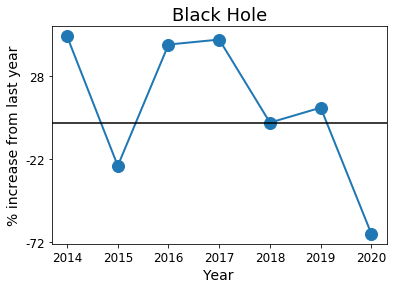

In [38]:
fig = Figure()
x_range=np.arange(2014,2021)
y_range = np.arange(min(rise)-5,max(rise)+20,50)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_range,rise,marker='o',lw=2,markersize=12)
ax.set_xticks(x_range)
ax.set_yticks(y_range)
ax.set_xticklabels(x_range,fontsize=12)
ax.set_yticklabels(y_range,fontsize=12)
ax.set_title(plot_title,fontsize=18)
ax.set_ylabel('% increase from last year',fontsize=14)
ax.set_xlabel('Year',fontsize=14)
ax.axhline(0,color='k')
fig

In [360]:
dill.dump(fig,open('trend_nn_pct.pkd','wb'))

In [2]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
fig = dill.load(open('trend_nn_pct.pkd', 'rb'))
canvas = FigureCanvas(fig)
canvas.draw()
filename = 'temp.png'
fig.savefig(filename, format='png')

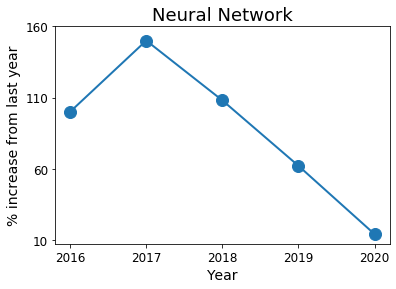

In [3]:
fig

In [26]:
trend

[17, 26, 19, 28, 42, 42, 46, 15]

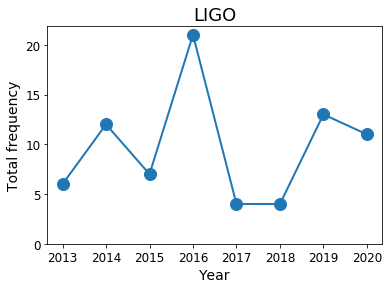

In [21]:
fig = Figure()
x_range=np.arange(2013,2021)
y_range = np.arange(0,25,5)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_range,trend,marker='o',lw=2,markersize=12)
ax.set_xticks(x_range)
ax.set_yticks(y_range)
ax.set_xticklabels(x_range,fontsize=12)
ax.set_yticklabels(y_range,fontsize=12)
ax.set_title(plot_title,fontsize=18)
ax.set_ylabel('Total frequency',fontsize=14)
ax.set_xlabel('Year',fontsize=14)
fig

In [363]:
dill.dump(fig,open('trend_nn_freq.pkd','wb'))

In [15]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(key_words) 

In [187]:
 # plot the WordCloud image

fig = Figure()
ax = fig.add_subplot(1, 1, 1)
#ax.imshow(wordcloud) 
#fig, ax = subplots()
#ax.plot(x,y)
ax.imshow(wordcloud)
ax.axis('off')

(-0.5, 799.5, 799.5, -0.5)

In [1]:
wordcloud.words_

NameError: name 'wordcloud' is not defined

In [102]:
titles_lemm_list = []
t0 = time.time()
#for i in range(1):
for title in titles_clean:
#    title = titles_clean[i]
    words = title.lower()
    title_lemm = tokenize_lemma(words)
    titles_lemm_list.append(' '.join(title_lemm))
time.time()-t0

63.843573808670044

In [89]:
stopwords_dict = Counter(stopwords)

In [104]:
t0 = time.time()
titles_no_stop_w_list = []
for title in titles_lemm_list:
#for title in [titles_lemm_list[1]]:
    words = title.split(' ')
    title_no_stop = words.copy()
    for word in words:
        #print(word)
        if stopwords_dict[word]:
            title_no_stop.remove(word)
    titles_no_stop_w_list.append(title_no_stop)
time.time()-t0

0.08620905876159668

In [240]:
features_clean = sorted(vocab_bi_tri(counts.get_feature_names())[0])
index_clean = sorted(vocab_bi_tri(counts.get_feature_names())[1])

In [241]:
counts = cv.fit_transform(titles_final)

tf = TfidfTransformer()
matrix = tf.fit_transform(counts)

In [242]:
matrix_reduced = matrix[:,index_clean]